In [3]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit import *
from torch import tensor
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

from pTrace import pTraceR_num, pTraceL_num
from src.coherence import coh_l1

from src.vqa_tools import general_vqacircuit_qiskit, train

def start_things(n_qubits, depht):
    n = 3*n_qubits*(1+depht)
    params = np.random.normal(0,np.pi/2, n)
    params = Variable(tensor(params), requires_grad=True)
    return n_qubits, params, depht, n

def optmize(epochs, n_qubits, circuit, params, target_op):

    best_params, f = train(epochs, circuit, params, target_op)
    parametros = tensor(best_params).detach().numpy()
    qc, qr = general_vqacircuit_qiskit(n_qubits, parametros)
    return qc, qr, best_params

def tomograph(qc, qr):
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])
    nshots = 8192
    job = execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    qstf = StateTomographyFitter(job.result(), qstc)
    rho = qstf.fit(method='lstsq')
    return rho

def results(rho, coerencias_R, coerencias_L):
    rhoA_R = pTraceR_num(2,2,rho)
    rhoA_L = pTraceL_num(2,2,rho)
    cA_R = coh_l1(rhoA_R)
    cA_L = coh_l1(rhoA_L)
    coerencias_R.append(cA_R)
    coerencias_L.append(cA_L)
    
    return coerencias_L, coerencias_R

def plots(list_p, coerencias_R, coerencias_L):
    plt.plot(list_p,coerencias_R,label='Rho_R')
    plt.plot(list_p,coerencias_L,label='Rho_L')
    plt.legend(loc=4)
    plt.show()


/tmp/ipykernel_16315/1835478858.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In [4]:
'''                                  ReadMe                                                      '''
'''# Nessa célula vamos apenas mudar a função geradora do estado a ser preparado                 '''
'''# Basta alterar a função que gera o estado, nesse caso target_op = init_state_ref(n_qubits, p)'''

from src.vqa_tools import general_vqacircuit_penny 
from src.state_initializer import  init_state_ref,init_state_bpf
from src.generalize import *
from torch import tensor
import numpy as np
import cmath
def state_amplitude_damping(theta, phi, p):
    state = np.zeros(4,dtype=complex)    
    state[0] = np.cos(theta/2)
    state[1] = np.sqrt(1-p)*cmath.exp(1j*phi)*np.sin(theta/2)
    state[2] = np.sqrt(p)
    target_op = np.outer(state, state)
    target_op = tensor(target_op)
    return target_op


def format_state(target_vector):
    #d = 2**n_qb
    #target_vector = general_state(np.pi/2, 0)
    target_op = np.outer(target_vector.conj(), target_vector)
    target_op = tensor(target_op)
    return target_op


def run_calcs(list_p, epochs):
    coerencias_R = []
    coerencias_L = []
    for p in list_p:

        n_qubits, params, depht, n = start_things(2, 3)

        circuit, _ = general_vqacircuit_penny(n_qubits, depht)

        #_, target_op = init_state_ref(n_qubits, p)
        #_, target_op = init_state_bpf(n_qubits, p)
        target_op = state_amplitude_damping(np.pi/2, 0, p)

        qc, qr, params = optmize(epochs, n_qubits, circuit, params, target_op)

        rho = tomograph(qc, qr)
        print(rho)
        coerencias_L, coerencias_R = results(rho, coerencias_R, coerencias_L)

    plots(list_p, coerencias_R, coerencias_L)
    

# 3 mar 2023

In [4]:
list_p = np.linspace(0,1,3)
list_p = [0,0.25,0.5,0.75,1]
run_calcs(list_p, 30)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'NoneType'

In [1]:
# RASCUNHO

In [ ]:
#import numpy as np
from src.tools import *
from pTrace import *
from qiskit import *
import qiskit
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from src.coherence import coh_l1

# Para fazer o processo para cada valor de p
#list_p = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
list_p = np.linspace(0,1,4)
n_qubits = 2
depht = 4
coerencias_R = []
coerencias_L = []
for p in list_p:
    print(f'p = {p} de {len(list_p)}')
    n = 3*n_qubits*(1+depht)
    params = np.random.normal(0,np.pi/2, n)
    params = Variable(torch.tensor(params), requires_grad=True)
    print(f'LEN PARAMS ={len(params)}')
    circuit, _ = general_vqacircuit_penny(n_qubits, depht)
    target_vector, target_op = init_state_ref(n_qubits, p)
    params, f = train(100, circuit, params, target_op)

    parametros = params.detach().numpy()
    qc, qr = general_vqacircuit_qiskit(n_qubits, parametros)

    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])
    nshots = 8192
    job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    qstf = StateTomographyFitter(job.result(), qstc)
    rho = qstf.fit(method='lstsq')
    rhoA_R = pTraceR_num(2,2,rho)
    rhoA_L = pTraceL_num(2,2,rho)
    #rhoA = pTraceR(2, 2, rho)
    cA_R = coh_l1(rhoA_R)
    cA_L = coh_l1(rhoA_L)
    coerencias_R.append(cA_R)
    coerencias_L.append(cA_L)

9
0 0.027237892150878906
1 0.0026788711547851562
2 9.5367431640625e-05
3 0.001377105712890625
4 0.00299072265625
5 0.00299072265625
6 0.006103515625
7 0.005222320556640625
8 0.00390625
9 0.0034332275390625
10 0.0009765625
11 0.00034427642822265625
12 6.103515625e-05
13 0.0
14 1.52587890625e-05
15 3.4332275390625e-05
16 0.00011539459228515625
17 0.0008020401000976562
18 0.000644683837890625
19 0.0010385513305664062


/tmp/ipykernel_84366/2146324961.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parametros = torch.tensor(best_params).detach().numpy()
/tmp/ipykernel_84366/2146324961.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = Variable(torch.tensor(best_params), requires_grad=True)


Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))
[[0.5015833+0.j]]
Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


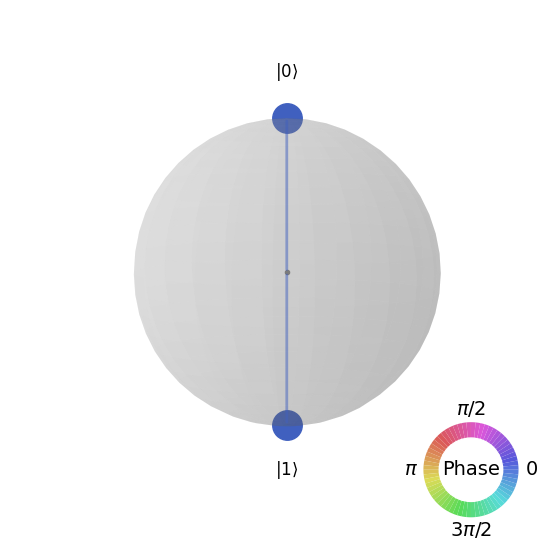

In [29]:

from src.state_initializer import init_state_gen_state
from src.vqa_tools import random_params
#import numpy as np
from src.tools import *
from pTrace import *
from qiskit import *
import qiskit
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from src.coherence import coh_l1

# Para fazer o processo para cada valor de p
#list_p = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
list_p = np.linspace(0,1,4)
n_qubits = 1
depht = 2
coerencias_R = []
coerencias_L = []
#params = random_params(n_qubits)
n = 3*n_qubits*(1+depht)
params = np.random.normal(0,np.pi/2, n)
params = Variable(torch.tensor(params), requires_grad=True)

print(len(params))
circuit, _ = general_vqacircuit_penny(n_qubits, depht)
target_vector, target_op = init_state_gen_state(n_qubits, p)
# print(type(best_params))
# import sys as s
# s.exit()
best_params, f = train(20, circuit, params, target_op)
parametros = torch.tensor(best_params).detach().numpy()
qc, qr = general_vqacircuit_qiskit(n_qubits, parametros)
params = Variable(torch.tensor(best_params), requires_grad=True)
qstc = state_tomography_circuits(qc, [qr[0]])
#qstc = state_tomography_circuits(qc, [qr[0],qr[1]])
nshots = 8192
job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
qstf = StateTomographyFitter(job.result(), qstc)
rho = qstf.fit(method='lstsq')
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
sv=Statevector.from_label('+')
print(sv)
plot_state_qsphere(sv)
rhoA_R = pTraceR_num(1,1,rho)
rhoA_L = pTraceL_num(1,1,rho)
state = [rhoA_R, rhoA_L]
print(rhoA_R)
target_vector_bloch = Statevector(target_vector)
sv2=Statevector(qc)
#plot_state_qsphere(sv)
print(target_vector_bloch)
plot_state_qsphere(target_vector_bloch)
##rhoA = pTraceR(2, 2, rho)
#cA_R = coh_l1(rhoA_R)
#cA_L = coh_l1(rhoA_L)
#coerencias_R.append(cA_R)
#coerencias_L.append(cA_L)

In [28]:
from src.state_initializer import init_state_gen_state
from src.vqa_tools import random_params
#import numpy as np
from src.tools import *
from pTrace import *
from qiskit import *
import qiskit
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from src.coherence import coh_l1

# Para fazer o processo para cada valor de p
#list_p = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
list_p = np.linspace(0,1,4)
n_qubits = 1
depht = 2
coerencias_R = []
coerencias_L = []
#params = random_params(n_qubits)
n = 3*n_qubits*(1+depht)
params = np.random.normal(0,np.pi/2, n)
params = Variable(torch.tensor(params), requires_grad=True)
    
    # n = 3*n_qubits*(1+depht)
    # params = np.random.normal(0,np.pi/2, n)
    # params = Variable(torch.tensor(params), requires_grad=True)
    print(len(params))
    circuit, _ = general_vqacircuit_penny(n_qubits, depht)
    target_vector, target_op = init_state_gen_state(n_qubits, p)
    params, f = train(20, circuit, params, target_op)
    # print(type(best_params))
    # import sys as s
    # s.exit()
    parametros = torch.tensor(params).detach().numpy()
    qc, qr = general_vqacircuit_qiskit(n_qubits, parametros)
    params = Variable(torch.tensor(params), requires_grad=True)
    qstc = state_tomography_circuits(qc, [qr[0]])
    #qstc = state_tomography_circuits(qc, [qr[0],qr[1]])
    nshots = 8192
    job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    qstf = StateTomographyFitter(job.result(), qstc)
    rho = qstf.fit(method='lstsq')

    from qiskit.quantum_info import Statevector
    from qiskit.visualization import plot_state_qsphere
    sv=Statevector.from_label('+')
    print(sv)
    plot_state_qsphere(sv)
    rhoA_R = pTraceR_num(1,1,rho)
    rhoA_L = pTraceL_num(1,1,rho)
    state = [rhoA_R, rhoA_L]
    print(rhoA_R)
    target_vector_bloch = Statevector(target_vector)
    sv2=Statevector(qc)
    #plot_state_qsphere(sv)
    print(target_vector_bloch)
    plot_state_qsphere(target_vector_bloch)
    ##rhoA = pTraceR(2, 2, rho)
    #cA_R = coh_l1(rhoA_R)
    #cA_L = coh_l1(rhoA_L)
    #coerencias_R.append(cA_R)
    #coerencias_L.append(cA_L)

p = 0.0 de 4
9
0 0.8408746719360352
1 0.5378732681274414
2 0.205322265625
3 0.054931640625
4 0.006103515625
5 0.0005044937133789062
6 0.002197265625
7 0.009159088134765625
8 0.035523414611816406
9 0.051774024963378906
10 0.0684967041015625
11 0.09888076782226562
12 0.0753030776977539
13 0.053566932678222656
14 0.040078163146972656
15 0.01763916015625
16 0.004281044006347656
17 0.0016031265258789062
18 0.000644683837890625
19 6.103515625e-05


/tmp/ipykernel_84366/1481087333.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parametros = torch.tensor(params).detach().numpy()
/tmp/ipykernel_84366/1481087333.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = Variable(torch.tensor(params), requires_grad=True)


Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))
[[0.50561329+0.j]]
Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))
p = 0.3333333333333333 de 4
9
0 1.52587890625e-05
1 0.0014505386352539062
2 0.0
3 0.0003814697265625
4 0.000644683837890625
5 0.000644683837890625
6 7.724761962890625e-05
7 9.5367431640625e-07
8 0.0
9 0.0001373291015625
10 0.0007476806640625
11 0.00027561187744140625
12 0.00011539459228515625
13 3.814697265625e-06
14 9.5367431640625e-07
15 1.52587890625e-05
16 2.384185791015625e-05
17 0.0001373291015625
18 0.00011539459228515625
19 0.0001373291015625
Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))
[[0.5450542+0.j]]
Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))
p = 0.6666666666666666 de 4
9
0 0.000186920166015625
1 0.000308990478515625
2 9.5367431640625e-05
3 0.0
4 8.58306884765625e-06
5 2.384185791015625e-05
6 7.724761962890625e-05
7 3.4332275390625e-05
8 0.0
9 0.0
10 0.0
11 2.38418579101

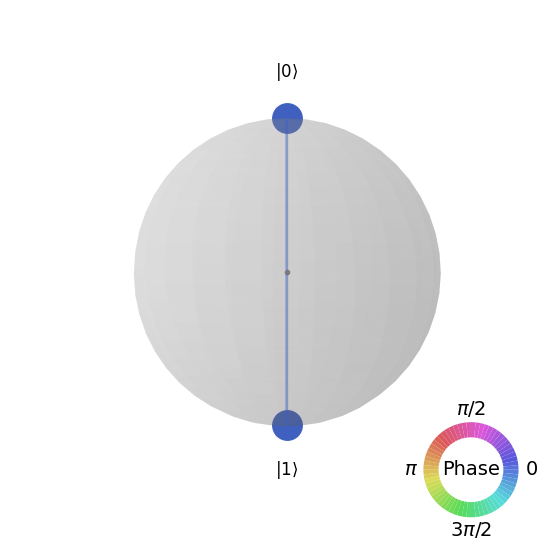

In [20]:
plot_state_qsphere(sv)


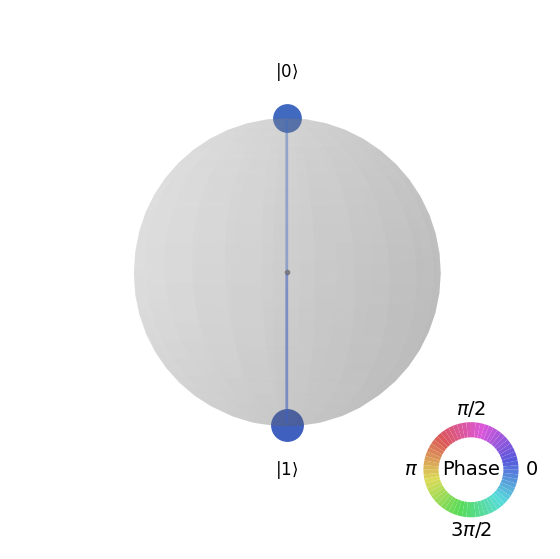

In [21]:
plot_state_qsphere(sv2)

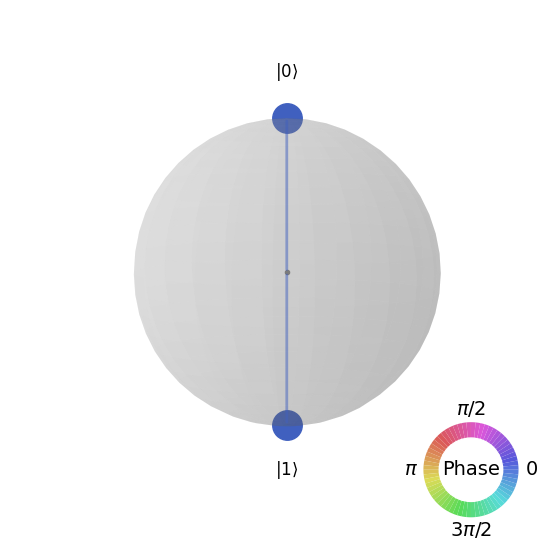

In [22]:
plot_state_qsphere(target_vector_bloch)
